In [14]:
import os

from src.utils import get_dataset
from src.vae.mnist_vae import ConditionalVae
import matplotlib.pyplot as plt
from src.impute import impute_cvae_naive
from tqdm import tqdm
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from src.image_classifier.exq_net_v1 import ExquisiteNetV1
import torch
from torch import nn, optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# binarize the data
class args:
    def __init__(self):
        self.num_channels = 1
        self.iid = 1
        self.num_classes = 10
        self.num_users = 10
        self.dataset = 'fmnist'

training_data, testing_data, user_groups = get_dataset(args())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         0., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
  

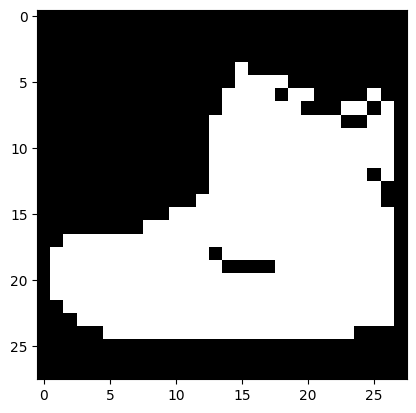

In [16]:
plt.imshow(training_data[0][0][0], cmap='gray')

print(training_data[0][0][0])

In [17]:
model = "cvae"
dataset = "fmnist"
batch_size = 32
epochs = 30
learning_rate = 0.001

model_path = f"../../models/{model}_{dataset}_{batch_size}_{epochs}_{learning_rate}.pt"

if os.path.exists(model_path):
    cvae_model = torch.load(model_path)
else:
    cvae = ConditionalVae(dim_encoding=3).to(device)

    # try with model sigma
    cvae_model, vae_loss_li, kl_loss_li, reg_loss_li = cvae.train_model(
        training_data=training_data,
        batch_size=batch_size,
        epochs=epochs,
        learning_rate=learning_rate
    )
    torch.save(cvae_model, model_path)

In [18]:
# generate synthetic data
gen_dataset = impute_cvae_naive(k=60000, trained_cvae = cvae_model, initial_dataset = torch.tensor([]))

In [19]:
# train classifier on gen data
model = "exq_v1"
dataset = "fmnist"
batch_size = 32
learning_rate = 0.001
epochs = 15

train_loader= DataLoader(gen_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

model_path = f"../../models/{model}_{dataset}_{batch_size}_{epochs}_{learning_rate}.pt"

classifier = ExquisiteNetV1(class_num=10, img_channels=1).to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

# Number of epochs to train the model
train_losses = []
test_losses = []
f1_scores = []
correct_predictions = 0
total_predictions = 0
for epoch in tqdm(range(epochs)):
    train_loss = 0.0
    pred_labels = []
    actual_labels = []
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = classifier(data)
        pred_labels.append(output.argmax(dim=1))
        actual_labels.append(target)

        # Calculate the loss
        loss = criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform single optimization step (parameter update)
        optimizer.step()

        # Update running training loss
        train_loss += loss.item() * data.size(0)

    # Switch to evaluation mode
    classifier.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_pred_labels = []
        test_actual_labels = []
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = classifier(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            test_pred_labels.append(output.argmax(dim=1))
            test_actual_labels.append(target)
             # Compare with actual classes
            total_predictions += output.argmax(dim=1).size(0)
            # correct_predictions += (predicted == labels).sum().item()
            correct_predictions += (output.argmax(dim=1) == target).sum().item()
            
    # Compute average test loss
    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    train_losses.append(train_loss)
    
    # Calculate F1 score for the test data
    test_pred_labels = torch.cat(test_pred_labels).to('cpu').numpy()
    test_actual_labels = torch.cat(test_actual_labels).to('cpu').numpy()
    test_f1_score = f1_score(test_actual_labels, test_pred_labels, average='macro')
    f1_scores.append(test_f1_score)
    accuracy = correct_predictions / total_predictions

    print(f'Accuracy: {accuracy * 100}%')
    print('Epoch: {} \tTraining Loss: {:.6f} \t Test Loss: {:.6f} \tF1 Test Macro: {:.6f}'.format(
        epoch + 1,
        train_loss,
        test_loss,
        test_f1_score
    ))
    
    # torch.save(classifier, model_path)

  7%|▋         | 1/15 [00:45<10:32, 45.16s/it]

Accuracy: 61.260000000000005%
Epoch: 1 	Training Loss: 0.711327 	 Test Loss: 1.337109 	F1 Test Macro: 0.610406


 13%|█▎        | 2/15 [01:30<09:47, 45.18s/it]

Accuracy: 62.075%
Epoch: 2 	Training Loss: 0.456686 	 Test Loss: 1.312935 	F1 Test Macro: 0.627798


 20%|██        | 3/15 [02:16<09:07, 45.65s/it]

Accuracy: 62.303333333333335%
Epoch: 3 	Training Loss: 0.352483 	 Test Loss: 1.578677 	F1 Test Macro: 0.627182


 27%|██▋       | 4/15 [03:02<08:23, 45.79s/it]

Accuracy: 62.262499999999996%
Epoch: 4 	Training Loss: 0.306485 	 Test Loss: 1.725541 	F1 Test Macro: 0.623262


 33%|███▎      | 5/15 [03:47<07:34, 45.49s/it]

Accuracy: 62.634%
Epoch: 5 	Training Loss: 0.275773 	 Test Loss: 1.608604 	F1 Test Macro: 0.640298


 40%|████      | 6/15 [04:33<06:51, 45.71s/it]

Accuracy: 62.91%
Epoch: 6 	Training Loss: 0.251868 	 Test Loss: 1.669938 	F1 Test Macro: 0.642543


 47%|████▋     | 7/15 [05:18<06:02, 45.37s/it]

Accuracy: 62.825714285714284%
Epoch: 7 	Training Loss: 0.234095 	 Test Loss: 1.851493 	F1 Test Macro: 0.626775


 53%|█████▎    | 8/15 [06:05<05:22, 46.09s/it]

Accuracy: 62.985%
Epoch: 8 	Training Loss: 0.219693 	 Test Loss: 1.628241 	F1 Test Macro: 0.640790


 60%|██████    | 9/15 [06:48<04:30, 45.11s/it]

Accuracy: 63.14666666666666%
Epoch: 9 	Training Loss: 0.205483 	 Test Loss: 1.722201 	F1 Test Macro: 0.644156


 60%|██████    | 9/15 [07:24<04:56, 49.36s/it]


KeyboardInterrupt: 

In [13]:
# test classifier with real testing data
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)

        # Pass the data to the model
        outputs = classifier(data)

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Compare with actual classes
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / total_predictions

print(f'Accuracy: {accuracy * 100}%')

Accuracy: 64.1%
